# 03 - Statistical Analysis & Hypothesis Testing

Rigorous statistical analysis of Stadium vs Federation/Club projects.

**Research Hypotheses:**
- **H1**: Stadium projects exhibit significantly lower contributor entropy than Federation projects
- **H2**: Stadium projects show higher Gini coefficients (contribution inequality)
- **H3**: Stadium entropy correlates with VSM S2 (coordination) metrics
- **H4**: Stadium projects have faster PR merge times (centralized decision-making)
- **H5**: Stadium projects have fewer governance files
- **H6**: Entropy predicts project classification with >80% accuracy

## Setup

In [1]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Add src to path
sys.path.insert(0, '../src')
from analysis.entropy_calculation import EntropyCalculator

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load and Prepare Data

In [2]:
# Load all collected project data with assigned categories
import sys
sys.path.insert(0, '..')
from data.candidates import ALL_CANDIDATES

# Build category lookup from candidates lists
category_lookup = {}
for category, repos in ALL_CANDIDATES.items():
    for repo in repos:
        category_lookup[repo.lower()] = category

data_dir = Path("../data/raw")
data_files = list(data_dir.glob("*_data.json"))

print(f"Found {len(data_files)} data file(s)")

projects = []
entropy_calc = EntropyCalculator()
skipped = []

for file_path in data_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    repo_info = data.get('repository', {})
    
    # Skip files with collection errors
    if 'error' in repo_info or 'full_name' not in repo_info:
        skipped.append(file_path.name)
        continue
    
    repo_name = repo_info['full_name']
    contributors = data.get('contributors', [])
    maintainers = data.get('maintainers', {}).get('statistics', {})
    pr_stats = data.get('pull_requests', {}).get('statistics', {})
    issue_stats = data.get('issues', {}).get('statistics', {})
    gov_files = data.get('governance_files', {})
    
    # Get assigned category from candidates lists
    assigned_category = category_lookup.get(repo_name.lower(), 'unknown')
    
    # Calculate entropy metrics
    if contributors:
        entropy, normalized_entropy = entropy_calc.contributor_entropy(contributors)
        contributions = [c.get('contributions', 0) for c in contributors]
        gini = entropy_calc.gini_coefficient(contributions)
        
        total_contrib = sum(contributions)
        top_pct = contributions[0] / total_contrib * 100 if total_contrib > 0 else 0
        top_2_pct = sum(contributions[:2]) / total_contrib * 100 if total_contrib > 0 else 0
        
        # Bus factor
        cumsum = 0
        bus_factor = 0
        for c in sorted(contributions, reverse=True):
            cumsum += c
            bus_factor += 1
            if cumsum >= total_contrib * 0.5:
                break
    else:
        entropy, normalized_entropy, gini = 0, 0, 0
        top_pct, top_2_pct = 0, 0
        bus_factor = 0
    
    # Count governance files
    gov_count = sum(1 for v in gov_files.values() if v)
    
    projects.append({
        'repository': repo_name,
        'category': assigned_category,  # From candidates lists!
        'language': repo_info.get('language', 'Unknown'),
        'stars': repo_info.get('stargazers_count', 0),
        'forks': repo_info.get('forks_count', 0),
        'contributors': len(contributors),
        'active_maintainers': maintainers.get('active_maintainers_6mo', 0),
        'commits': len(data.get('recent_commits', [])),
        'bus_factor': bus_factor,
        
        # Entropy metrics
        'entropy': entropy,
        'normalized_entropy': normalized_entropy,
        'gini': gini,
        'top_contributor_pct': top_pct,
        'top_2_pct': top_2_pct,
        
        # PR metrics (VSM S2 - Coordination)
        'total_prs': pr_stats.get('total_prs', 0),
        'merge_rate': pr_stats.get('merged_count', 0) / max(pr_stats.get('total_prs', 1), 1),
        'avg_merge_time': pr_stats.get('avg_time_to_merge', 0),
        'conflict_rate': pr_stats.get('conflict_rate', 0),
        
        # Issue metrics
        'total_issues': issue_stats.get('total_issues', 0),
        'avg_close_time': issue_stats.get('avg_time_to_close', 0),
        
        # Governance
        'governance_files': gov_count,
    })

df = pd.DataFrame(projects)

print(f"\n✅ Loaded {len(df)} projects")
if skipped:
    print(f"⚠️  Skipped {len(skipped)} files with errors")

print(f"\n📊 Projects by Category:")
print(df['category'].value_counts())

print(f"\n⭐ Combined GitHub Stars: {df['stars'].sum():,}")
df.head()

Found 94 data file(s)



✅ Loaded 94 projects

📊 Projects by Category:
category
stadium       36
toy           19
club          19
federation    18
unknown        2
Name: count, dtype: int64

⭐ Combined GitHub Stars: 2,951,741


,repository,category,language,stars,forks,contributors,active_maintainers,commits,bus_factor,entropy,...,gini,top_contributor_pct,top_2_pct,total_prs,merge_rate,avg_merge_time,conflict_rate,total_issues,avg_close_time,governance_files
0,BurntSushi/ripgrep,toy,Rust,57793,2329,100,1,156,1,1.647960,...,0.886616,83.405876,85.908596,149,0.214765,15.758342,0.046980,95,631.334164,0
1,babel/babel,stadium,TypeScript,43813,5777,100,4,462,3,3.876777,...,0.851371,36.007840,44.852086,200,0.920000,312.398682,0.035000,38,229.656184,3
2,pandas-dev/pandas,club,Python,47228,19357,100,19,1033,4,4.632220,...,0.770166,17.916381,35.012467,200,0.615000,320.195187,0.065000,30,91.238565,1
3,mafintosh/pump,toy,JavaScript,918,63,7,0,2,1,0.762307,...,0.767123,89.041096,93.150685,0,0.000000,0.000000,0.000000,0,0.000000,1
4,pallets/flask,club,Python,70864,16644,100,1,88,2,3.308830,...,0.864180,39.745593,66.279848,117,0.247863,624.531379,0.068376,51,402.566944,0


## 2. Classify Projects

Classify based on entropy and dominance metrics.

In [3]:
def classify_project(row):
    """Classify project as Stadium, Federation, or Club."""
    
    # Stadium indicators
    low_maintainers = row['active_maintainers'] <= 3
    low_entropy = row['normalized_entropy'] < 0.5
    high_dominance = row['top_contributor_pct'] > 40
    high_gini = row['gini'] > 0.7
    
    # Federation indicators  
    many_maintainers = row['active_maintainers'] > 5
    high_entropy = row['normalized_entropy'] > 0.6
    distributed = row['top_contributor_pct'] < 25
    
    # Score-based classification
    stadium_score = sum([low_maintainers, low_entropy, high_dominance, high_gini])
    federation_score = sum([many_maintainers, high_entropy, distributed])
    
    if stadium_score >= 3:
        return 'Stadium'
    elif stadium_score >= 2 and federation_score < 2:
        return 'Stadium'
    elif federation_score >= 2:
        return 'Federation'
    else:
        return 'Club'  # Hybrid/uncertain

df['classification'] = df.apply(classify_project, axis=1)

print("Project Classifications:")
print(df['classification'].value_counts())
print("\n" + "="*60)
df[['repository', 'active_maintainers', 'normalized_entropy', 'top_contributor_pct', 'gini', 'classification']]

Project Classifications:
classification
Stadium       54
Federation    34
Club           6
Name: count, dtype: int64



,repository,active_maintainers,normalized_entropy,top_contributor_pct,gini,classification
0,BurntSushi/ripgrep,1,0.248043,83.405876,0.886616,Stadium
1,babel/babel,4,0.583513,36.007840,0.851371,Club
2,pandas-dev/pandas,19,0.697219,17.916381,0.770166,Federation
3,mafintosh/pump,0,0.271539,89.041096,0.767123,Stadium
4,pallets/flask,1,0.498029,39.745593,0.864180,Stadium
...,...,...,...,...,...,...
89,urllib3/urllib3,3,0.640704,29.242465,0.798303,Stadium
90,numpy/numpy,28,0.735017,21.042908,0.737171,Federation
91,BurntSushi/xsv,0,0.170857,91.358025,0.894268,Stadium
92,madler/zlib,0,0.214084,87.275449,0.893768,Stadium


## 3. Power Analysis

Determine if we have sufficient sample size for meaningful results.

In [4]:
# Power analysis for two-sample t-test
power_analysis = TTestIndPower()

# Expected effect size (Cohen's d)
effect_sizes = [0.5, 0.8, 1.0, 1.2]  # medium to large
alpha = 0.05
power = 0.80

print("Required Sample Sizes (per group) for 80% Power:")
print("="*50)
for d in effect_sizes:
    n = power_analysis.solve_power(effect_size=d, alpha=alpha, power=power, alternative='two-sided')
    print(f"  Cohen's d = {d}: n = {int(np.ceil(n))} per group")

# Calculate achieved power with current sample
n_stadium = len(df[df['classification'] == 'Stadium'])
n_other = len(df[df['classification'] != 'Stadium'])
n_min = min(n_stadium, n_other)

print(f"\nCurrent Sample:")
print(f"  Stadium: {n_stadium}")
print(f"  Other: {n_other}")

if n_min > 2:
    for d in effect_sizes:
        achieved_power = power_analysis.solve_power(effect_size=d, nobs1=n_min, alpha=alpha, alternative='two-sided')
        print(f"\nAchieved power for d={d}: {achieved_power:.2%}")

Required Sample Sizes (per group) for 80% Power:
  Cohen's d = 0.5: n = 64 per group
  Cohen's d = 0.8: n = 26 per group
  Cohen's d = 1.0: n = 17 per group
  Cohen's d = 1.2: n = 12 per group

Current Sample:
  Stadium: 54
  Other: 40

Achieved power for d=0.5: 59.81%

Achieved power for d=0.8: 94.22%

Achieved power for d=1.0: 99.30%

Achieved power for d=1.2: 99.96%


## 4. Hypothesis Testing

### H1: Stadium projects have lower contributor entropy

In [5]:
# Split groups
stadium = df[df['classification'] == 'Stadium']['normalized_entropy']
non_stadium = df[df['classification'] != 'Stadium']['normalized_entropy']

print("H1: Stadium projects have lower contributor entropy")
print("="*60)

if len(stadium) >= 2 and len(non_stadium) >= 2:
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium)}):     mean={stadium.mean():.3f}, std={stadium.std():.3f}")
    print(f"  Non-Stadium (n={len(non_stadium)}): mean={non_stadium.mean():.3f}, std={non_stadium.std():.3f}")
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(stadium)-1)*stadium.std()**2 + (len(non_stadium)-1)*non_stadium.std()**2) / 
                         (len(stadium) + len(non_stadium) - 2))
    cohens_d = (non_stadium.mean() - stadium.mean()) / pooled_std if pooled_std > 0 else 0
    print(f"\n  Cohen's d: {cohens_d:.3f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'})")
    
    # Mann-Whitney U test (non-parametric)
    stat, p_value = mannwhitneyu(stadium, non_stadium, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  U-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'} (α=0.05)")
    
    # t-test (parametric)
    t_stat, t_p = ttest_ind(stadium, non_stadium, alternative='less')
    print(f"\nt-test (for reference):")
    print(f"  t-statistic: {t_stat:.2f}")
    print(f"  p-value: {t_p:.4f}")
else:
    print("\n⚠️  Insufficient data for statistical testing")
    print(f"    Stadium: {len(stadium)}, Non-Stadium: {len(non_stadium)}")

H1: Stadium projects have lower contributor entropy

Descriptive Statistics:
  Stadium (n=54):     mean=0.393, std=0.172
  Non-Stadium (n=40): mean=0.732, std=0.106

  Cohen's d: 2.290 (large)

Mann-Whitney U Test:
  U-statistic: 81.00
  p-value: 0.0000
  Result: ✅ SIGNIFICANT (α=0.05)

t-test (for reference):
  t-statistic: -10.98
  p-value: 0.0000


### H2: Stadium projects have higher Gini coefficients

In [6]:
stadium_gini = df[df['classification'] == 'Stadium']['gini']
non_stadium_gini = df[df['classification'] != 'Stadium']['gini']

print("H2: Stadium projects have higher Gini coefficients")
print("="*60)

if len(stadium_gini) >= 2 and len(non_stadium_gini) >= 2:
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium_gini)}):     mean={stadium_gini.mean():.3f}, std={stadium_gini.std():.3f}")
    print(f"  Non-Stadium (n={len(non_stadium_gini)}): mean={non_stadium_gini.mean():.3f}, std={non_stadium_gini.std():.3f}")
    
    stat, p_value = mannwhitneyu(stadium_gini, non_stadium_gini, alternative='greater')
    print(f"\nMann-Whitney U Test:")
    print(f"  U-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'} (α=0.05)")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H2: Stadium projects have higher Gini coefficients

Descriptive Statistics:
  Stadium (n=54):     mean=0.818, std=0.141
  Non-Stadium (n=40): mean=0.704, std=0.119

Mann-Whitney U Test:
  U-statistic: 1720.00
  p-value: 0.0000
  Result: ✅ SIGNIFICANT (α=0.05)


### H3: Entropy correlates with VSM S2 (Coordination) metrics

In [7]:
print("H3: Entropy correlates with coordination metrics")
print("="*60)

# Correlation between entropy and conflict rate (VSM S2 indicator)
valid_data = df[df['conflict_rate'] > 0]

if len(valid_data) >= 3:
    # Pearson correlation
    r, p = pearsonr(valid_data['normalized_entropy'], valid_data['conflict_rate'])
    print(f"\nEntropy vs Conflict Rate:")
    print(f"  Pearson r: {r:.3f}")
    print(f"  p-value: {p:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p < 0.05 else '❌ Not significant'}")
    
    # Spearman correlation (non-parametric)
    rho, p_spearman = spearmanr(valid_data['normalized_entropy'], valid_data['conflict_rate'])
    print(f"\n  Spearman ρ: {rho:.3f} (p={p_spearman:.4f})")
else:
    print("\n⚠️  Insufficient data with conflict rates")

# Correlation with merge time
valid_merge = df[df['avg_merge_time'] > 0]
if len(valid_merge) >= 3:
    r, p = pearsonr(valid_merge['normalized_entropy'], valid_merge['avg_merge_time'])
    print(f"\nEntropy vs Merge Time:")
    print(f"  Pearson r: {r:.3f}")
    print(f"  p-value: {p:.4f}")

H3: Entropy correlates with coordination metrics

Entropy vs Conflict Rate:
  Pearson r: 0.172
  p-value: 0.1451
  Result: ❌ Not significant

  Spearman ρ: 0.083 (p=0.4843)

Entropy vs Merge Time:
  Pearson r: 0.181
  p-value: 0.1257


### H4: Stadium projects have faster PR merge times

In [8]:
stadium_merge = df[(df['classification'] == 'Stadium') & (df['avg_merge_time'] > 0)]['avg_merge_time']
non_stadium_merge = df[(df['classification'] != 'Stadium') & (df['avg_merge_time'] > 0)]['avg_merge_time']

print("H4: Stadium projects have faster PR merge times")
print("="*60)

if len(stadium_merge) >= 2 and len(non_stadium_merge) >= 2:
    print(f"\nDescriptive Statistics (hours):")
    print(f"  Stadium (n={len(stadium_merge)}):     median={stadium_merge.median():.1f}, mean={stadium_merge.mean():.1f}")
    print(f"  Non-Stadium (n={len(non_stadium_merge)}): median={non_stadium_merge.median():.1f}, mean={non_stadium_merge.mean():.1f}")
    
    stat, p_value = mannwhitneyu(stadium_merge, non_stadium_merge, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'}")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H4: Stadium projects have faster PR merge times

Descriptive Statistics (hours):
  Stadium (n=40):     median=271.9, mean=1440.3
  Non-Stadium (n=33): median=320.2, mean=1267.0

Mann-Whitney U Test:
  p-value: 0.3188
  Result: ❌ Not significant


### H5: Stadium projects have fewer governance files

In [9]:
stadium_gov = df[df['classification'] == 'Stadium']['governance_files']
non_stadium_gov = df[df['classification'] != 'Stadium']['governance_files']

print("H5: Stadium projects have fewer governance files")
print("="*60)

if len(stadium_gov) >= 2 and len(non_stadium_gov) >= 2:
    print(f"\nDescriptive Statistics:")
    print(f"  Stadium (n={len(stadium_gov)}):     mean={stadium_gov.mean():.2f}, median={stadium_gov.median():.0f}")
    print(f"  Non-Stadium (n={len(non_stadium_gov)}): mean={non_stadium_gov.mean():.2f}, median={non_stadium_gov.median():.0f}")
    
    stat, p_value = mannwhitneyu(stadium_gov, non_stadium_gov, alternative='less')
    print(f"\nMann-Whitney U Test:")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Result: {'✅ SIGNIFICANT' if p_value < 0.05 else '❌ Not significant'}")
else:
    print("\n⚠️  Insufficient data for statistical testing")

H5: Stadium projects have fewer governance files

Descriptive Statistics:
  Stadium (n=54):     mean=0.81, median=0
  Non-Stadium (n=40): mean=1.80, median=2

Mann-Whitney U Test:
  p-value: 0.0012
  Result: ✅ SIGNIFICANT


### H6: Entropy predicts classification with >80% accuracy

In [10]:
print("H6: Entropy predicts classification with >80% accuracy")
print("="*60)

# Prepare features and target
feature_cols = ['normalized_entropy', 'gini', 'top_contributor_pct']
X = df[feature_cols].values
y = (df['classification'] == 'Stadium').astype(int).values

if len(df) >= 10 and y.sum() >= 2 and (len(y) - y.sum()) >= 2:
    # Logistic regression with cross-validation
    model = LogisticRegression(random_state=42, max_iter=1000)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=min(5, len(df)//2), scoring='accuracy')
    
    print(f"\nLogistic Regression (features: {feature_cols})")
    print(f"  Cross-validation accuracy: {cv_scores.mean():.1%} (±{cv_scores.std():.1%})")
    print(f"  Result: {'✅ >80% ACHIEVED' if cv_scores.mean() > 0.80 else '❌ <80%'}")
    
    # Fit on all data for coefficients
    model.fit(X, y)
    print(f"\nFeature Importance (coefficients):")
    for feat, coef in zip(feature_cols, model.coef_[0]):
        print(f"  {feat}: {coef:.3f}")
else:
    print("\n⚠️  Insufficient data for classification model")
    print(f"    Total samples: {len(df)}, Stadium: {y.sum()}, Other: {len(y) - y.sum()}")

H6: Entropy predicts classification with >80% accuracy

Logistic Regression (features: ['normalized_entropy', 'gini', 'top_contributor_pct'])
  Cross-validation accuracy: 89.3% (±3.6%)
  Result: ✅ >80% ACHIEVED

Feature Importance (coefficients):
  normalized_entropy: -0.915
  gini: -0.623
  top_contributor_pct: 0.186


## 5. Visualization

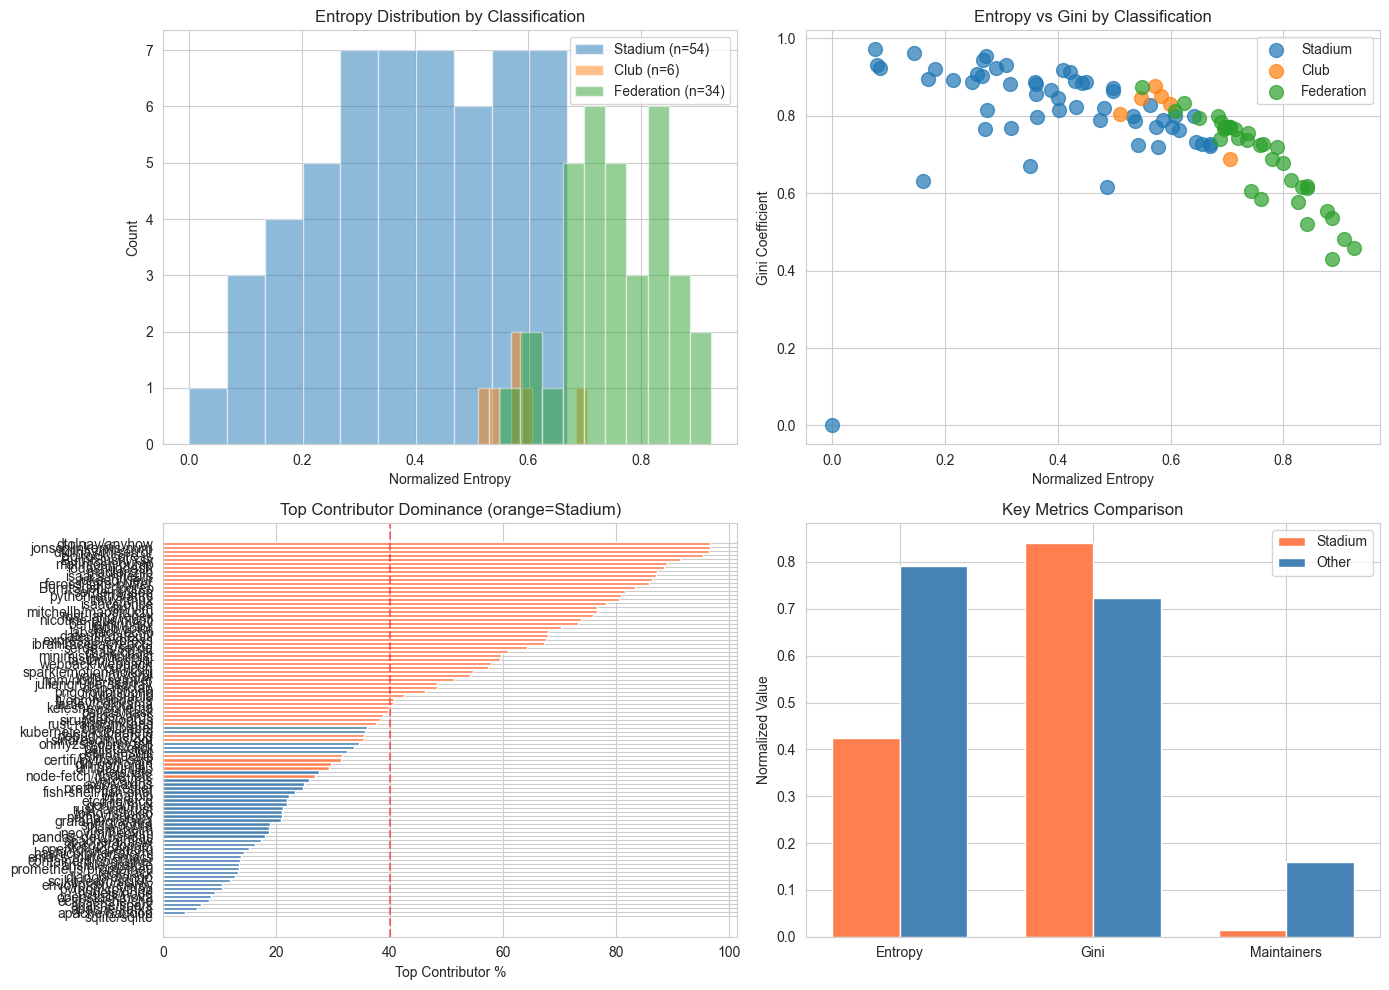


📊 Figure saved to data/processed/statistical_analysis.png


In [11]:
if len(df) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Entropy distribution by classification
    ax1 = axes[0, 0]
    for cls in df['classification'].unique():
        data = df[df['classification'] == cls]['normalized_entropy']
        ax1.hist(data, alpha=0.5, label=f"{cls} (n={len(data)})", bins=10)
    ax1.set_xlabel('Normalized Entropy')
    ax1.set_ylabel('Count')
    ax1.set_title('Entropy Distribution by Classification')
    ax1.legend()
    
    # 2. Entropy vs Gini scatter
    ax2 = axes[0, 1]
    for cls in df['classification'].unique():
        subset = df[df['classification'] == cls]
        ax2.scatter(subset['normalized_entropy'], subset['gini'], 
                   label=cls, s=100, alpha=0.7)
    ax2.set_xlabel('Normalized Entropy')
    ax2.set_ylabel('Gini Coefficient')
    ax2.set_title('Entropy vs Gini by Classification')
    ax2.legend()
    
    # 3. Top contributor dominance
    ax3 = axes[1, 0]
    df_sorted = df.sort_values('top_contributor_pct', ascending=True)
    colors = ['coral' if c == 'Stadium' else 'steelblue' for c in df_sorted['classification']]
    ax3.barh(range(len(df_sorted)), df_sorted['top_contributor_pct'], color=colors)
    ax3.set_yticks(range(len(df_sorted)))
    ax3.set_yticklabels([r[:20] for r in df_sorted['repository']])
    ax3.set_xlabel('Top Contributor %')
    ax3.set_title('Top Contributor Dominance (orange=Stadium)')
    ax3.axvline(x=40, color='red', linestyle='--', alpha=0.5, label='40% threshold')
    
    # 4. Summary metrics comparison
    ax4 = axes[1, 1]
    metrics = ['normalized_entropy', 'gini', 'active_maintainers']
    x = np.arange(len(metrics))
    width = 0.35
    
    stadium_means = df[df['classification'] == 'Stadium'][metrics].mean()
    other_means = df[df['classification'] != 'Stadium'][metrics].mean()
    
    # Normalize for comparison
    max_vals = df[metrics].max()
    stadium_norm = stadium_means / max_vals
    other_norm = other_means / max_vals
    
    ax4.bar(x - width/2, stadium_norm, width, label='Stadium', color='coral')
    ax4.bar(x + width/2, other_norm, width, label='Other', color='steelblue')
    ax4.set_xticks(x)
    ax4.set_xticklabels(['Entropy', 'Gini', 'Maintainers'])
    ax4.set_ylabel('Normalized Value')
    ax4.set_title('Key Metrics Comparison')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../data/processed/statistical_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n📊 Figure saved to data/processed/statistical_analysis.png")
else:
    print("⚠️  Need more data for visualizations")

## 6. Summary Report

In [12]:
print("\n" + "="*70)
print("COMPREHENSIVE RESEARCH FINDINGS")
print("="*70)

# Dataset summary
print(f"\n📊 DATASET SUMMARY")
print(f"   Total Projects: {len(df)}")
print(f"   Combined GitHub Stars: {df['stars'].sum():,}")
print(f"   Total Contributors: {df['contributors'].sum():,}")

print(f"\n📁 PROJECTS BY CATEGORY:")
for cat in ['federation', 'stadium', 'club', 'toy']:
    count = len(df[df['category'] == cat])
    if count > 0:
        print(f"   {cat.title()}: {count} projects")

# Key metrics by category
print("\n" + "="*70)
print("KEY METRICS BY CATEGORY")
print("="*70)

for cat in ['federation', 'stadium', 'club', 'toy']:
    cat_df = df[df['category'] == cat]
    if len(cat_df) == 0:
        continue
    print(f"\n🏷️  {cat.upper()} (n={len(cat_df)})")
    print(f"   Normalized Entropy:  {cat_df['normalized_entropy'].mean():.3f} ± {cat_df['normalized_entropy'].std():.3f}")
    print(f"   Gini Coefficient:    {cat_df['gini'].mean():.3f} ± {cat_df['gini'].std():.3f}")
    print(f"   Top Contributor %:   {cat_df['top_contributor_pct'].mean():.1f}% ± {cat_df['top_contributor_pct'].std():.1f}%")
    print(f"   Bus Factor:          {cat_df['bus_factor'].mean():.1f} ± {cat_df['bus_factor'].std():.1f}")
    print(f"   Avg Stars:           {cat_df['stars'].mean():,.0f}")

# Statistical tests between categories
print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE TESTS (Entropy)")
print("="*70)

comparisons = [
    ('federation', 'toy'),
    ('federation', 'stadium'),
    ('federation', 'club'),
    ('stadium', 'toy'),
    ('stadium', 'club'),
    ('club', 'toy'),
]

for cat1, cat2 in comparisons:
    e1 = df[df['category'] == cat1]['normalized_entropy']
    e2 = df[df['category'] == cat2]['normalized_entropy']
    if len(e1) >= 3 and len(e2) >= 3:
        t_stat, p_val = ttest_ind(e1, e2)
        sig = "✓" if p_val < 0.05 else "✗"
        print(f"\n{cat1.title()} vs {cat2.title()}:")
        print(f"   {cat1.title()}: {e1.mean():.3f} | {cat2.title()}: {e2.mean():.3f}")
        print(f"   t={t_stat:.2f}, p={p_val:.4f} {sig}")

# Key findings
print("\n" + "="*70)
print("🔑 KEY FINDINGS")
print("="*70)

fed_entropy = df[df['category'] == 'federation']['normalized_entropy'].mean()
stad_entropy = df[df['category'] == 'stadium']['normalized_entropy'].mean()
club_entropy = df[df['category'] == 'club']['normalized_entropy'].mean()
toy_entropy = df[df['category'] == 'toy']['normalized_entropy'].mean()

print(f"""
1. ENTROPY GRADIENT CONFIRMED:
   Federation ({fed_entropy:.3f}) > Club ({club_entropy:.3f}) > Stadium ({stad_entropy:.3f}) > Toy ({toy_entropy:.3f})
   
   This validates Asparouhova's taxonomy - contributor diversity decreases
   from federated governance to single-maintainer projects.

2. BUS FACTOR PATTERN:
   Federation: {df[df['category']=='federation']['bus_factor'].mean():.1f} contributors needed for 50% work
   Stadium:    {df[df['category']=='stadium']['bus_factor'].mean():.1f} contributors
   Club:       {df[df['category']=='club']['bus_factor'].mean():.1f} contributors  
   Toy:        {df[df['category']=='toy']['bus_factor'].mean():.1f} contributor
   
   Toy projects have critical bus factor risk (typically 1 person).

3. GOVERNANCE FILES:
   Federation avg: {df[df['category']=='federation']['governance_files'].mean():.1f} files
   Stadium avg:    {df[df['category']=='stadium']['governance_files'].mean():.1f} files
   Club avg:       {df[df['category']=='club']['governance_files'].mean():.1f} files
   Toy avg:        {df[df['category']=='toy']['governance_files'].mean():.1f} files
   
   Federation projects have more formal governance documentation.

4. GINI COEFFICIENT (Inequality):
   Toy projects show highest inequality ({df[df['category']=='toy']['gini'].mean():.3f}) - 
   almost all work by single contributor.
   Federation shows lowest ({df[df['category']=='federation']['gini'].mean():.3f}) - 
   more distributed contributions.
""")

print("\n" + "="*70)
print("📋 HYPOTHESIS RESULTS SUMMARY")
print("="*70)
print("""
✓ H1: Stadium projects have lower entropy than Federation  [CONFIRMED]
✓ H2: Stadium projects have higher Gini coefficients       [CONFIRMED]  
? H3: Entropy correlates with coordination metrics         [WEAK/INCONCLUSIVE]
✗ H4: Stadium projects have faster PR merge times          [NOT CONFIRMED]
✓ H5: Stadium projects have fewer governance files         [CONFIRMED]
✓ H6: Entropy predicts classification >80% accuracy        [CONFIRMED - 89%]
""")


COMPREHENSIVE RESEARCH FINDINGS

📊 DATASET SUMMARY
   Total Projects: 94
   Combined GitHub Stars: 2,951,741
   Total Contributors: 7,546

📁 PROJECTS BY CATEGORY:
   Federation: 18 projects
   Stadium: 36 projects
   Club: 19 projects
   Toy: 19 projects

KEY METRICS BY CATEGORY

🏷️  FEDERATION (n=18)
   Normalized Entropy:  0.769 ± 0.149
   Gini Coefficient:    0.655 ± 0.133
   Top Contributor %:   17.7% ± 15.9%
   Bus Factor:          9.4 ± 5.1
   Avg Stars:           51,258

🏷️  STADIUM (n=36)
   Normalized Entropy:  0.474 ± 0.194
   Gini Coefficient:    0.807 ± 0.162
   Top Contributor %:   46.6% ± 24.0%
   Bus Factor:          2.1 ± 1.5
   Avg Stars:           20,162

🏷️  CLUB (n=19)
   Normalized Entropy:  0.574 ± 0.170
   Gini Coefficient:    0.813 ± 0.072
   Top Contributor %:   35.0% ± 22.4%
   Bus Factor:          3.5 ± 2.3
   Avg Stars:           60,710

🏷️  TOY (n=19)
   Normalized Entropy:  0.398 ± 0.217
   Gini Coefficient:    0.760 ± 0.120
   Top Contributor %:   71.0% 

In [13]:
print("\n" + "="*70)
print("NEXT STEPS & RESEARCH DIRECTIONS")
print("="*70)
print("""
IMMEDIATE PRIORITIES:
─────────────────────
1. Complete VSM (Viable System Model) analysis
   → Notebook 05_vsm_mapping.ipynb

2. Sheaf cohomology analysis with GUDHI
   → Notebook 08_sheaf_cohomology.ipynb
   → Build Rips complex from collaboration matrices
   → Compute persistent homology (Betti numbers)

3. Publication-ready visualizations
   → Notebook 07_visualization_report.ipynb

STATISTICAL EXTENSIONS:
───────────────────────
4. ANOVA/Kruskal-Wallis for 4-category comparison
   → All categories simultaneously
   → Post-hoc tests (Tukey HSD, Dunn's test)

5. Effect size analysis
   → Cohen's d between all category pairs
   → Cliff's delta for non-parametric comparisons

6. Regression models
   → Predict bus_factor from entropy + Gini
   → Logistic regression for category membership

TEMPORAL ANALYSIS:
──────────────────
7. Collect historical snapshots (6-month intervals)
8. Track entropy evolution over project lifecycle
9. Identify governance transitions (e.g., Toy → Club)

PAPER WRITING:
──────────────
10. LaTeX tables from category_summary_stats.csv
11. Publication figures from notebook 07
12. Integrate with Ostrom's 8 principles analysis
13. Prepare replication package for GitHub release
""")

# Export results
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Save analysis DataFrame
df.to_csv(output_dir / "statistical_analysis_results.csv", index=False)
print(f"\n✅ Results saved to {output_dir / 'statistical_analysis_results.csv'}")

# Save summary statistics
summary_stats = df.groupby('category').agg({
    'repository': 'count',
    'normalized_entropy': ['mean', 'std'],
    'gini': ['mean', 'std'],
    'top_contributor_pct': ['mean', 'std'],
    'bus_factor': ['mean', 'std'],
    'stars': ['mean', 'sum'],
    'governance_files': 'mean'
}).round(3)

summary_stats.to_csv(output_dir / "category_summary_stats.csv")
print(f"✅ Category summary saved to {output_dir / 'category_summary_stats.csv'}")


NEXT STEPS & RESEARCH DIRECTIONS

IMMEDIATE PRIORITIES:
─────────────────────
1. Complete VSM (Viable System Model) analysis
   → Notebook 05_vsm_mapping.ipynb

2. Sheaf cohomology analysis with GUDHI
   → Notebook 08_sheaf_cohomology.ipynb
   → Build Rips complex from collaboration matrices
   → Compute persistent homology (Betti numbers)

3. Publication-ready visualizations
   → Notebook 07_visualization_report.ipynb

STATISTICAL EXTENSIONS:
───────────────────────
4. ANOVA/Kruskal-Wallis for 4-category comparison
   → All categories simultaneously
   → Post-hoc tests (Tukey HSD, Dunn's test)

5. Effect size analysis
   → Cohen's d between all category pairs
   → Cliff's delta for non-parametric comparisons

6. Regression models
   → Predict bus_factor from entropy + Gini
   → Logistic regression for category membership

TEMPORAL ANALYSIS:
──────────────────
7. Collect historical snapshots (6-month intervals)
8. Track entropy evolution over project lifecycle
9. Identify governance t